# Import Libraries

In [1]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (193 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import numpy as np

import faiss # Fast KNN Library (better than ScikitLearn)

import os

# Global configurations




In [3]:
# Set random seed
torch.manual_seed(43)

# Global onfigurations
batch_size = 16 # This will be multiplied by 4 
num_classes = 4
lr = 0.1
val_size = 5000
classes = ('0', '90', '180', '270')
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint/'

# Fast KNN Classifier

In [4]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

    def score(self, predict, y):
        return np.sum(predict == y) / len(y)

# Resnet18 architecture

stage determines the number of resnet blocks in training : [1, 2, 3, 4]

Stage=4 is used for training in all runs

In [5]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_classes, stage = 4): # Stage
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.stage = stage

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # Stride=1 for first layer
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Stage
        linear_in = [64, 128, 256, 512]
        self.linear = nn.Linear(linear_in[self.stage - 1] *block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # Stage
        out = self.layer1(out)
        if self.stage > 1:
          out = self.layer2(out)
        if self.stage > 2:
          out = self.layer3(out)
        if self.stage > 3:
          out = self.layer4(out)
        # Stage
        out = F.avg_pool2d(out, 64 // 2**self.stage) # Global average Pooling instead of MaxPool
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


print('testing... output size: ')
net = ResNet(BasicBlock, [2, 2, 2, 2], stage = 1)
y = net(torch.randn(1, 3, 32, 32))
print(y.size())

testing... output size: 
torch.Size([1, 4])


# Rotation_net

This class contains functions for loading and augmenting dataset and training self-supervised model

In [6]:

class rotation_net():

  def __init__(self):
    pass

  ################################ Helper functions ###############################


  #__________load the dataset____________________

  def load_cifar10(self):
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, drop_last=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2, drop_last=True)
    
    print('cifar10 downloaded')
    print('size of train, val, test:')
    print(len(trainset), len(testset))


  #_________load_model_from_checkpoint____________

  def load_from_checkpoint(self):
      try:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load(checkpoint_dir + str(4) + 'ckpt.pth')
        self.net.load_state_dict(checkpoint['net'])
        self.best_acc = checkpoint['acc']
        self.start_epoch = checkpoint['epoch']
          
        print('best accuracy and epoch:')
        print(self.best_acc)
        print(self.start_epoch)

      except:
        a = input('no checkpoint detected... start from beginning? (y/n)')
        if a == 'n':
          exit()
  
  #_____________Save_checkpoint__________________

  def save_checkpoint(self, acc, epoch):

        if acc > self.best_acc:
          print('Saving..')
          state = {
              'net': self.net.state_dict(),
              'acc': acc,
              'epoch': epoch,
          }
          if not os.path.isdir(checkpoint_dir):
              os.mkdir(checkpoint_dir)
          torch.save(state, checkpoint_dir + str(4) + 'ckpt.pth')
          self.best_acc = acc

  #________function_to_show_an_image grid__________

  def imshow(self, img):
      img = img / 2 + 0.5     # unnormalize
      img = img.cpu()
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()


  #___forward_hook_to_get_intermediate_layer_outputs___

  def get_activation(self, name):
      def hook(model, input, output):
          self.activation[name] = output.detach()
      return hook


  ################################ Training Functions #################################

  # The following functions are used for the first part of the question and model training

  #____________Training_main_function_________________________

  def train_pipeline(self, stage = 4, resume = 0, augment_mode = 'rot', dif_rots=False):

    self.stage = stage
    self.net = ResNet(BasicBlock, [2, 2, 2, 2], self.stage)
    self.net = self.net.to('cuda')

    # Loss & optimizer
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.net.parameters(), lr=lr,
                          momentum=0.9, weight_decay=5e-4)

    self.start_epoch = 0
    self.best_acc = 0

    # resuming training
    if resume:
      self.load_from_checkpoint()

    for epoch in range(self.start_epoch, 100):
        self.train_step(epoch, augment_mode, dif_rots = dif_rots)
        self.test_step(epoch)


  #__________________Training_step____________________________

  def train_step(self, epoch, augment_mode = 'rot', dif_rots = False):
      print('\nEpoch: %d' % epoch)
      self.net.train()
      train_loss = 0
      correct = 0
      total = 0
      for batch_idx, (inputs, targets) in enumerate(self.trainloader):

          inputs = inputs.cuda()
          targets = targets.cuda()

          #_________Augmentation modes_______________

          if augment_mode == 'rot': #Only rotation 
            x, y = self.rotate_func(inputs, dif_rots = dif_rots)
          elif augment_mode == 'rot_cut': #First rotation then cutMix: cutmix changes targets
            x, y = self.rotate_func(inputs)
            x, y_a, y_b, lam = self.cutmix_func(x, y)
          elif augment_mode == 'cut_rot': #First cutMix then rotation: cutmix does not change targets
            x, _, _, _ = self.cutmix_func(inputs, targets)
            x, y = self.rotate_func(x)
          #__________________________________________

          self.optimizer.zero_grad()
          outputs = self.net(x)

          # Loss changes. cutMixed picture contains mixed patches of different roations from the original image
          if augment_mode == 'rot_cut':
            loss = self.criterion(outputs, y_a) * lam + self.criterion(outputs, y_b) * (1. - lam)
          else:
            loss = self.criterion(outputs, y)

          loss.backward()
          self.optimizer.step()

          train_loss += loss.item()
          _, predicted = outputs.max(1)
          total += y.size(0)
          correct += predicted.eq(y).sum().item()

          if batch_idx % 1125 == 0:
            print('[%d, %5d] Loss: %.3f | Acc: %.3f (%d/%d)' % (batch_idx, len(self.trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))


  #___________ Inference_step_(targets are self-supervised)_____________

  def test_step(self, epoch):
      global best_acc
      self.net.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(self.testloader):

              inputs = inputs.cuda()
              # Self defined function (rotation augmentation)
              x, y = self.rotate_func(inputs)

              outputs = self.net(x)
              loss = self.criterion(outputs, y)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += y.size(0)
              correct += predicted.eq(y).sum().item()
             
      print('Test: Loss: %.3f | Acc: %.3f (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

      # Save checkpoint
      acc = 100.*correct/total
      self.save_checkpoint(acc, epoch)


  ################################ Augmentation Functions ################################


  #________Apply rotation augmentation_____________

  def rotate_func(self, inputs, show_output=False, dif_rots=False): #dif_rots related to 3rd part of question

    x = torch.empty(size=(4, batch_size, 3, 32, 32)).cuda()
    y = torch.empty(size=(4, batch_size)).cuda()

    if dif_rots == True: # Only keep one rotation for each image
      assert (batch_size % 4) == 0
      for i in range(4):
          # indeces for 1/4th of batch
          start = int((batch_size/4) * i)
          end = int((batch_size/4) * (i+1))
          x[0, start:end] = torch.rot90(inputs[start:end], i, [2, 3]) 
          y[0, start:end] = torch.tensor(np.full((batch_size//4), i))
      x[1], y[1] = x[0], y[0] # Just duplicate 
      x[2], y[2] = x[1], y[1]
      x[3], y[3] = x[2], y[2]

    else: # normal mode (keep 4 rotations for each image in batch)
      rotation_choices = [i for i in range(4)]
      for i in rotation_choices:
          x[i] = torch.rot90(inputs, i, [2, 3])
          y[i] = torch.tensor(np.full((batch_size), i))

    x = torch.reshape(x, (4* batch_size, 3, 32, 32))
    y = torch.reshape(y, (4* batch_size, )).type(torch.cuda.LongTensor)
    if show_output:
      self.imshow(torchvision.utils.make_grid(x))
      print(y)
      print(x.size(), y.size())

    return x, y

  #_____________________Cutmix________________________

  # Generate bounding box positions (lambda is rand uniform 0-1 and determines ratio of cut)
  def rand_bbox(self, size, lam):
      W = size[2]
      H = size[3]
      cut_rat = np.sqrt(1. - lam)
      cut_w = np.int(W * cut_rat)
      cut_h = np.int(H * cut_rat)

      # uniform
      cx = np.random.randint(W)
      cy = np.random.randint(H)

      bbx1 = np.clip(cx - cut_w // 2, 0, W)
      bby1 = np.clip(cy - cut_h // 2, 0, H)
      bbx2 = np.clip(cx + cut_w // 2, 0, W)
      bby2 = np.clip(cy + cut_h // 2, 0, H)

      return bbx1, bby1, bbx2, bby2


  #_______Main cutmix function_______

  def cutmix_func(self, inputs, targets, show_output=False):
    
    inputs.cuda()
    targets.cuda()
    
    # generate mixed sample
    # Official implementation uses beta distribution (a=1 & b=1): equivalent to uniform distribution
    lam = np.random.uniform()
    rand_index = torch.randperm(inputs.size()[0]).cuda()
    target_a = targets
    target_b = targets[rand_index]
    bbx1, bby1, bbx2, bby2 = self.rand_bbox(inputs.size(), lam)
    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * images.size()[-2]))
    
    if show_output == True:
      rn.imshow(torchvision.utils.make_grid(inputs))

    return inputs, target_a, target_b, lam



  ########################## Supervised Evaluation ##############################


  #____________main function_______________________

  # this function evaluates representations with KNN classifier
  def evaluate(self, stages = [1, 2, 3, 4]):

    # Preparing trained model
    self.net = ResNet(BasicBlock, [2, 2, 2, 2])
    self.load_from_checkpoint()
    self.net.eval()
    self.net.to('cuda')

    # Register different stage outputs
    self.activation = {}
    self.net.layer1.register_forward_hook(self.get_activation('layer1'))
    self.net.layer2.register_forward_hook(self.get_activation('layer2'))
    self.net.layer3.register_forward_hook(self.get_activation('layer3'))
    self.net.layer4.register_forward_hook(self.get_activation('layer4'))

    for i in stages:
      print("stage " + str(i))
      # Generate train and test features and targets
      X_train, y_train = self.generate_dataset(mode = 'train', stage = i)
      X_test, y_test = self.generate_dataset(mode = 'test', stage = i)

      # Use Nearest Neighbor as Classifier
      neigh = FaissKNeighbors(k=1)
      neigh.fit(X_train, y_train)
      print('accuracy: ', neigh.score(neigh.predict(X_test), y_test))
      print("*"*10)


  #_________Creating train and test representation datasets______________

  def generate_dataset(self, mode = 'train', stage = 1):

    if mode == 'train':
      dataset = self.trainloader
      dataset_len = 50000
    else:
      dataset = self.testloader
      dataset_len = 10000

    new_X = []
    new_y = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataset):

            inputs = inputs.cuda()
            targets = targets.cuda()

            _ = self.net(inputs) # Pass input to model. output doesnt matter, intermediate layers are registered...

            repr = F.avg_pool2d(self.activation['layer' + str(stage)], 64 // 2**stage) # Global average pool
            repr = repr.view(repr.size(0), -1)

            new_X.append(repr.detach().cpu().numpy())
            new_y.append(targets.detach().cpu().numpy())

    new_X = np.array(new_X).reshape((dataset_len, -1))
    new_y = np.array(new_y).reshape((dataset_len))
    print(mode + 'data ' + 'new x and y shapes ', np.shape(new_X), np.shape(new_y))

    return new_X, new_y


# Part 1: Rotation Augmentation

## Load data

below shows a generated batch of 64 images from rotating 16 images

Files already downloaded and verified
Files already downloaded and verified
cifar10 downloaded
size of train, val, test:
50000 10000


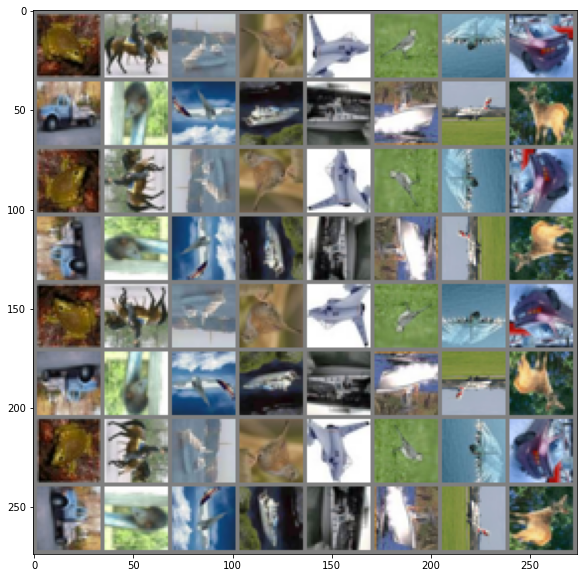

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [ ]:
plt.figure(figsize=(10, 10))

rn = rotation_net()
rn.load_cifar10()

# get some random training images
dataiter = iter(rn.trainloader)
images, labels = dataiter.next()

# Test dataset and Rotation augmentation
_, _ = rn.rotate_func(images.cuda(), show_output=True)

## Train

Training is done for 26 epochs

Epoch: 11      Test: Loss: 0.513 | Acc: 80.567 (32227/40000)

Model does a great job of recognizing rotations! Test dataset contains original Cifar10 Images with no rotation. The model should recognize that all images are straight. The Self-Supervised test logic stays same for next steps.


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint/'

rn.train_pipeline(stage = 4, resume = 0, augment_mode= 'rot')


Epoch: 0
[0,  3125] Loss: 1.457 | Acc: 15.625 (10/64)
[1125,  3125] Loss: 1.191 | Acc: 48.615 (35034/72064)
[2250,  3125] Loss: 1.096 | Acc: 53.076 (76463/144064)
Test: Loss: 0.907 | Acc: 62.430 (24972/40000)
Saving..

Epoch: 1
[0,  3125] Loss: 0.897 | Acc: 62.500 (40/64)
[1125,  3125] Loss: 0.882 | Acc: 63.890 (46042/72064)
[2250,  3125] Loss: 0.855 | Acc: 65.196 (93924/144064)
Test: Loss: 0.839 | Acc: 65.847 (26339/40000)
Saving..

Epoch: 2
[0,  3125] Loss: 0.971 | Acc: 62.500 (40/64)
[1125,  3125] Loss: 0.714 | Acc: 71.360 (51425/72064)
[2250,  3125] Loss: 0.697 | Acc: 72.291 (104146/144064)
Test: Loss: 0.628 | Acc: 75.528 (30211/40000)
Saving..

Epoch: 3
[0,  3125] Loss: 0.874 | Acc: 67.188 (43/64)
[1125,  3125] Loss: 0.630 | Acc: 75.767 (54601/72064)
[2250,  3125] Loss: 0.623 | Acc: 75.915 (109366/144064)
Test: Loss: 0.621 | Acc: 75.965 (30386/40000)
Saving..

Epoch: 4
[0,  3125] Loss: 0.652 | Acc: 75.000 (48/64)
[1125,  3125] Loss: 0.575 | Acc: 78.050 (56246/72064)
[2250,  3125]

## Evaluate

Supervised evaluation for all 4 stages is done and accuracy is 0.5348% at best.

Stage 3 gives better and more general features than stage 4. Cause Cifar10 is easy and small?

In [ ]:
rn.evaluate(stages = [1, 2, 3, 4])

==> Resuming from checkpoint..
best accuracy and epoch:
80.5675
11
stage 1
traindata new x and y shapes  (50000, 64) (50000,)
testdata new x and y shapes  (10000, 64) (10000,)
accuracy:  0.3777
**********
stage 2
traindata new x and y shapes  (50000, 128) (50000,)
testdata new x and y shapes  (10000, 128) (10000,)
accuracy:  0.4626
**********
stage 3
traindata new x and y shapes  (50000, 256) (50000,)
testdata new x and y shapes  (10000, 256) (10000,)
accuracy:  0.5348
**********
stage 4
traindata new x and y shapes  (50000, 512) (50000,)
testdata new x and y shapes  (10000, 512) (10000,)
accuracy:  0.4675
**********


# Part 2: Rotation + CutMix Augmentation


## Load data
As seen below, position of mixed patch is constant for different rotations, but the rotations don't match the original image's rotations. So each image contains 2 rotations within itself! This might add complications in learning!

label corresponds only to rotation of original image, but in loss we consider this! thats why training accuracy starts from lower than 25% (random accuracy)

Files already downloaded and verified
Files already downloaded and verified
cifar10 downloaded
size of train, val, test:
50000 10000


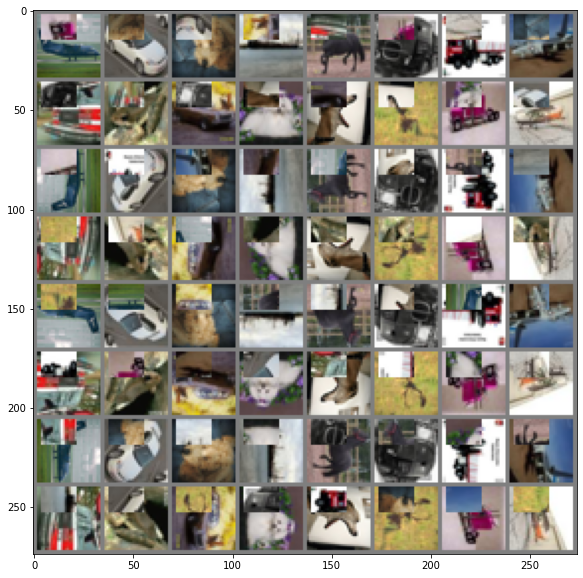

In [ ]:
plt.figure(figsize=(10, 10))

rn = rotation_net()
rn.load_cifar10()

# get some random training images
dataiter = iter(rn.trainloader)
images, labels = dataiter.next()

#First rotation then cutMix: cutmix changes targets
x, y = rn.rotate_func(images)
x, y_a, y_b, lam = rn.cutmix_func(x, y, show_output=True)


## Training

Epoch: 10     Test: Loss: 0.689 | Acc: 74.170 (29668/40000)

Training is done for 26 epochs

The task becomes harder for model.

Test dataset only contains rotations and no cutmix.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_rotcut/'

rn.train_pipeline(stage = 4, resume = 0, augment_mode = 'rot_cut')


Epoch: 0
[0,  3125] Loss: 1.424 | Acc: 21.875 (14/64)
[1125,  3125] Loss: 1.342 | Acc: 39.573 (28518/72064)
[2250,  3125] Loss: 1.287 | Acc: 43.740 (63013/144064)
Test: Loss: 1.009 | Acc: 57.680 (23072/40000)
Saving..

Epoch: 1
[0,  3125] Loss: 1.364 | Acc: 37.500 (24/64)
[1125,  3125] Loss: 1.156 | Acc: 53.490 (38547/72064)
[2250,  3125] Loss: 1.134 | Acc: 54.790 (78932/144064)
Test: Loss: 0.775 | Acc: 69.112 (27645/40000)
Saving..

Epoch: 2
[0,  3125] Loss: 1.216 | Acc: 53.125 (34/64)
[1125,  3125] Loss: 1.072 | Acc: 58.924 (42463/72064)
[2250,  3125] Loss: 1.064 | Acc: 59.621 (85892/144064)
Test: Loss: 0.828 | Acc: 67.795 (27118/40000)

Epoch: 3
[0,  3125] Loss: 1.206 | Acc: 50.000 (32/64)
[1125,  3125] Loss: 1.040 | Acc: 61.005 (43963/72064)
[2250,  3125] Loss: 1.037 | Acc: 61.196 (88161/144064)
Test: Loss: 0.802 | Acc: 69.218 (27687/40000)
Saving..

Epoch: 4
[0,  3125] Loss: 0.933 | Acc: 73.438 (47/64)
[1125,  3125] Loss: 1.025 | Acc: 62.184 (44812/72064)
[2250,  3125] Loss: 1.02

## Evaluation

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_rotcut/'

rn.evaluate(stages = [3])

==> Resuming from checkpoint..
best accuracy and epoch:
74.17
10
stage 3
traindata new x and y shapes  (50000, 256) (50000,)
testdata new x and y shapes  (10000, 256) (10000,)
accuracy:  0.5232
**********


# Part 2: CutMix + Rotation Augmentation

As seen below, the rotations match the original image's rotations.

label corresponds only to rotation of original image, but in loss we consider this! thats why training accuracy starts from lower than 25% (random accuracy)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cifar10 downloaded
size of train, val, test:
50000 10000


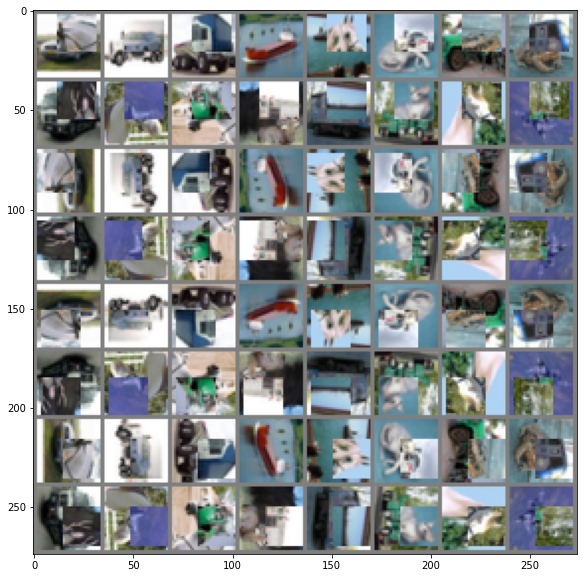

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [ ]:
plt.figure(figsize=(10, 10))

rn = rotation_net()
rn.load_cifar10()

# get some random training images
dataiter = iter(rn.trainloader)
images, labels = dataiter.next()

#First cutMix then rotation: The cutMixed image rotation is same with original image
x, y_a, y_b, lam = rn.cutmix_func(images, labels)
x, y = rn.rotate_func(images, show_output=True)

## Training

Epoch: 10     Test: Loss: 0.597 | Acc: 77.007 (30803/40000)

Task is easier for model than last step. logical...

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_cutrot/'

rn.train_pipeline(stage = 4, resume = 1, augment_mode = 'cut_rot')

==> Resuming from checkpoint..
best accuracy and epoch:
73.3375
4

Epoch: 4
[0,  3125] Loss: 0.782 | Acc: 70.312 (45/64)
[1125,  3125] Loss: 0.601 | Acc: 76.630 (55223/72064)
[2250,  3125] Loss: 0.603 | Acc: 76.593 (110343/144064)
Test: Loss: 0.706 | Acc: 73.010 (29204/40000)

Epoch: 5
[0,  3125] Loss: 0.261 | Acc: 90.625 (58/64)
[1125,  3125] Loss: 0.593 | Acc: 77.073 (55542/72064)
[2250,  3125] Loss: 0.590 | Acc: 77.235 (111268/144064)
Test: Loss: 0.695 | Acc: 73.263 (29305/40000)

Epoch: 6
[0,  3125] Loss: 0.614 | Acc: 73.438 (47/64)
[1125,  3125] Loss: 0.576 | Acc: 77.750 (56030/72064)
[2250,  3125] Loss: 0.576 | Acc: 77.860 (112168/144064)
Test: Loss: 0.713 | Acc: 71.737 (28695/40000)

Epoch: 7
[0,  3125] Loss: 0.619 | Acc: 81.250 (52/64)
[1125,  3125] Loss: 0.574 | Acc: 77.997 (56208/72064)
[2250,  3125] Loss: 0.571 | Acc: 78.169 (112613/144064)
Test: Loss: 0.809 | Acc: 69.640 (27856/40000)

Epoch: 8
[0,  3125] Loss: 0.689 | Acc: 68.750 (44/64)
[1125,  3125] Loss: 0.566 | Acc: 78

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_cutrot/'

rn.evaluate(stages = [3])

==> Resuming from checkpoint..
best accuracy and epoch:
77.0075
10
stage 3
traindata new x and y shapes  (50000, 256) (50000,)
testdata new x and y shapes  (10000, 256) (10000,)
accuracy:  0.4969
**********


# Part 3: Different Rotations

## Load data

In the first 2 rows, a specific and distinct rotation is applied to each group of 4 consequtive images. The other rows are just replicas of the first 2 rows


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
cifar10 downloaded
size of train, val, test:
50000 10000


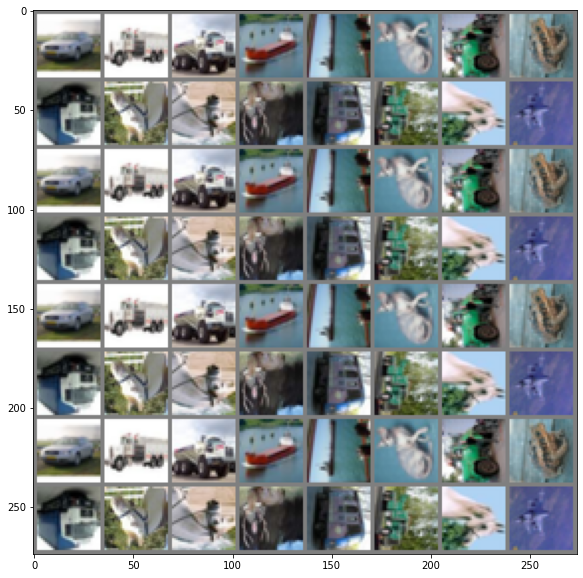

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
        0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], device='cuda:0')
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [7]:
plt.figure(figsize=(10, 10))

rn = rotation_net()
rn.load_cifar10()

# get some random training images
dataiter = iter(rn.trainloader)
images, labels = dataiter.next()

# Test dataset and Rotation augmentation
_, _ = rn.rotate_func(images.cuda(), show_output=True, dif_rots=True) # This function now takes a new input

## Train

Training is done for 26 epochs

Epoch: 11     Test: Loss: 0.942 | Acc: 60.575 (24230/40000)

Not bad, but this task is harder for model than the first step

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_dif_rot/'

rn.train_pipeline(stage = 4, resume = 0, augment_mode= 'rot', dif_rots = True) # This function now passes dif_rots to rot_func


Epoch: 0
[0,  3125] Loss: 1.546 | Acc: 18.750 (12/64)
[1125,  3125] Loss: 1.462 | Acc: 32.627 (23512/72064)
[2250,  3125] Loss: 1.297 | Acc: 41.107 (59220/144064)
Test: Loss: 1.115 | Acc: 49.708 (19883/40000)
Saving..

Epoch: 1
[0,  3125] Loss: 0.939 | Acc: 62.500 (40/64)
[1125,  3125] Loss: 1.077 | Acc: 53.552 (38592/72064)
[2250,  3125] Loss: 1.060 | Acc: 54.451 (78444/144064)
Test: Loss: 1.117 | Acc: 51.250 (20500/40000)
Saving..

Epoch: 2
[0,  3125] Loss: 1.383 | Acc: 37.500 (24/64)
[1125,  3125] Loss: 1.021 | Acc: 56.672 (40840/72064)
[2250,  3125] Loss: 1.020 | Acc: 57.089 (82244/144064)
Test: Loss: 1.018 | Acc: 56.428 (22571/40000)
Saving..

Epoch: 3
[0,  3125] Loss: 1.034 | Acc: 43.750 (28/64)
[1125,  3125] Loss: 1.000 | Acc: 58.220 (41956/72064)
[2250,  3125] Loss: 1.004 | Acc: 58.019 (83584/144064)
Test: Loss: 1.004 | Acc: 57.318 (22927/40000)
Saving..

Epoch: 4
[0,  3125] Loss: 0.947 | Acc: 68.750 (44/64)
[1125,  3125] Loss: 0.994 | Acc: 58.592 (42224/72064)
[2250,  3125] L

## Evaluate

Supervised evaluation for all 4 stages is done and accuracy is 32.57% at best.

Worse than normal rotation

In [9]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_1/checkpoint_dif_rot/'

rn.evaluate(stages = [1, 2, 3, 4])

==> Resuming from checkpoint..
best accuracy and epoch:
60.575
16
stage 1
traindata new x and y shapes  (50000, 64) (50000,)
testdata new x and y shapes  (10000, 64) (10000,)
accuracy:  0.1781
**********
stage 2
traindata new x and y shapes  (50000, 128) (50000,)
testdata new x and y shapes  (10000, 128) (10000,)
accuracy:  0.3001
**********
stage 3
traindata new x and y shapes  (50000, 256) (50000,)
testdata new x and y shapes  (10000, 256) (10000,)
accuracy:  0.3257
**********
stage 4
traindata new x and y shapes  (50000, 512) (50000,)
testdata new x and y shapes  (10000, 512) (10000,)
accuracy:  0.2945
**********
